## Create Images.

Using a class to create images from the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) based on the maximum imagesize given by 'get_largest_dimension.py' of 3264.  I have set my image generators to only keep images of a specified size, picsize.

In [68]:
from dog_images import DogImages

picsize = 600

# three for testing purposes
lst_dogs = ['n02088364-beagle', 
            'n02109047-Great_Dane', 
            'n02110185-Siberian_husky',
            'n02102318-cocker_spaniel']
dog_images = DogImages(lst_dogs, picsize)
dog_images.generate_img_files()
train_imgs = dog_images.load_images('train')
test_imgs = dog_images.load_images('test')
Xtest = test_imgs[0]
Ytest = test_imgs[1]
Xtrain = train_imgs[0]
Ytrain = train_imgs[1]




In [60]:
import numpy as np
Xhold = Xtrain.copy()
Yhold = Ytrain.copy()
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtrain[i, :] = Xhold[n, :]
    Ytrain[i, :] = Yhold[n, :]
    
Xhold = Xtest
Yhold = Ytest
new = np.array([i for i in range(Xhold.shape[0])])
np.random.shuffle(new)
for i, n in enumerate(new):
    Xtest[i, :] = Xhold[n, :]
    Ytest[i, :] = Yhold[n, :]

## Single layer network...
A fully connected network with no hidden layers

![Fully Connected Network With No Hidden Layers](WebImages\fully_connected.png)

In [61]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [62]:
# Set-Up
y = tf.placeholder(tf.float32, [None, len(lst_dogs)])
# three channels, picsize of picsize
X = tf.placeholder(tf.float32, [None, picsize*picsize*3])

# Weights & bias...
W = tf.Variable(tf.truncated_normal([picsize*picsize*3, len(lst_dogs)], stddev=0.1), name='W')
b = tf.Variable(tf.truncated_normal([len(lst_dogs),], stddev=0.1), name='b')

# Math
y_hat = tf.nn.softmax(tf.matmul(X, W) + b)
loss_function = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat) + 0.01 * tf.nn.l2_loss(W)
prediction = tf.argmax(y_hat, axis=1)
correct_prediction = tf.equal(prediction, tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))

In [63]:
# Run it...
LEARNING_RATE = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_minimizer = optimizer.minimize(loss_function)
save_W = tf.zeros_like(W)
print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}% '.format(0.0, 0.0), end='')
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    slides = 20
    num_batches =  Xtrain.shape[0]/slides
    for step in range(int(num_batches)):
        xbatch = Xtrain[i*slides:i*slides + slides - 1] 
        ybatch = Ytrain[i*slides:i*slides + slides - 1]
        sess.run(train_minimizer, {X : xbatch, y : ybatch})
        y_pred = sess.run(y_hat, {X: Xtest})
        prediction = tf.argmax(y_pred, axis=1)
        correct_prediction = tf.equal(prediction, tf.argmax(Ytest, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
        print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}%'.format(100*(step+1)/num_batches, accuracy.eval()*100), end='')
    ans = tf.argmax(Ytest, axis=1).eval()
    pred = prediction.eval()
    print('{} \r'.format(' '*50), end='')
    print('Accuracy {:.2f}% \r'.format(accuracy.eval()*100))
    save_W = W.eval()

Accuracy 46.83% 


Not the best.  We need some hidden layers.  But first, I want to see *eigenpuppies*:

In [64]:
from math import sqrt

def plot_digit_weights(ax, image): 
    """Plot the weights from our fit fully connected network as an image."""
    size = image.shape[0]
    n = int(sqrt(size/3))
    img = image.reshape(n,n,3)
    ax.imshow(img)

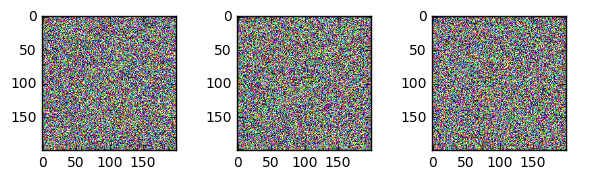

In [65]:

fig, axs = plt.subplots(1, 3)
for n, ax in enumerate(axs.flatten()):
    plot_digit_weights(ax, save_W[:,n])
plt.tight_layout()
plt.show()

In [56]:
sess.close()

## Single hidden Layer
Trying with a single hidden layer...

![Single Hidden Layer](WebImages/single_layer.png)

Where N is somenumber of hidden features...

In [66]:

for N in range(len(lst_dogs), len(lst_dogs)*11, len(lst_dogs)):
    # Set-Up
    y = tf.placeholder(tf.float32, [None, len(lst_dogs)])
    # three channels, picsize of picsize
    X = tf.placeholder(tf.float32, [None, picsize*picsize*3])

    # Weights & bias...
    W1 = tf.Variable(tf.truncated_normal([picsize*picsize*3, N], stddev=0.1), name='W1')
    b1 = tf.Variable(tf.truncated_normal([N,], stddev=0.1), name='b1')
    
    # Run it...
    X1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    # Weights & bias...
    W2 = tf.Variable(tf.truncated_normal([N, len(lst_dogs)], stddev=0.1), name='W2')
    b2 = tf.Variable(tf.truncated_normal([len(lst_dogs),], stddev=0.1), name='b2')

    # Math
    y_hat = tf.nn.softmax(tf.matmul(X1, W2) + b2)
    loss_function = (tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat) + 
                     0.01 * tf.nn.l2_loss(W1) +
                     0.01 * tf.nn.l2_loss(W2))
    prediction = tf.argmax(y_hat, axis=1)
    correct_prediction = tf.equal(prediction, tf.argmax(y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
    
    # Run it...
    LEARNING_RATE = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
    train_minimizer = optimizer.minimize(loss_function)
    print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}% '.format(0.0, 0.0), end='')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        slides = 20
        num_batches =  Xtrain.shape[0]/slides
        for step in range(int(num_batches)):
            xbatch = Xtrain[i*slides:i*slides + slides - 1] 
            ybatch = Ytrain[i*slides:i*slides + slides - 1]
            sess.run(train_minimizer, {X : xbatch, y : ybatch})
            y_pred = sess.run(y_hat, {X: Xtest})
            prediction = tf.argmax(y_pred, axis=1)
            correct_prediction = tf.equal(prediction, tf.argmax(Ytest, axis=1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype='float32'))
            print('\r Percent Complete: {:.2f}% - Accuracy {:.2f}%'.format(100*(step+1)/num_batches, accuracy.eval()*100), end='')
        ans = tf.argmax(Ytest, axis=1).eval()
        pred = prediction.eval()
        print('\r {}'.format(' '*50), end='')
        print('Accuracy for N = {}: {:.2f}%'.format(N, accuracy.eval()*100))
        save_W = W.eval()

                                                   Accuracy for N = 3: 33.73%
                                                   Accuracy for N = 6: 50.79%
                                                   Accuracy for N = 9: 49.21%
                                                   Accuracy for N = 12: 25.00%
                                                   Accuracy for N = 15: 48.02%
                                                   Accuracy for N = 18: 48.81%
                                                   Accuracy for N = 21: 33.33%
                                                   Accuracy for N = 24: 51.19%
                                                   Accuracy for N = 27: 23.81%
                                                   Accuracy for N = 30: 13.89%
